# Kalman Filter (Pyro)

In this notebook, we will be using the Kalman Filter version from the Pyro Library.

In [1]:
import math
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LinearHMMReparam, StableReparam, SymmetricStableReparam
from pyro.ops.tensor_utils import periodic_repeat
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt

## Data

In [2]:
from pyro.contrib.tracking.dynamic_models import NcvContinuous

dt = 1e-2
num_frames = 10
dim = 4

# Continuous model
ncv = NcvContinuous(dim, 2.0)

# Truth trajectory
xs_truth = torch.zeros(num_frames, dim)
# initial direction
theta0_truth = 0.0
# initial state
with torch.no_grad():
    xs_truth[0, :] = torch.tensor([0.0, 0.0,  math.cos(theta0_truth), math.sin(theta0_truth)])
    for frame_num in range(1, num_frames):
        # sample independent process noise
        dx = pyro.sample('process_noise_{}'.format(frame_num), ncv.process_noise_dist(dt))
        xs_truth[frame_num, :] = ncv(xs_truth[frame_num-1, :], dt=dt) + dx

In [3]:
num_frames = 10

# Measurements
measurements = []
mean = torch.zeros(2)
# no correlations
cov = 1e-5 * torch.eye(2)
with torch.no_grad():
    # sample independent measurement noise
    dzs = pyro.sample('dzs', dist.MultivariateNormal(mean, cov).expand((num_frames,)))
    # compute measurement means
    zs = xs_truth[:, :2] + dzs

In [5]:
zs.shape

torch.Size([10, 2])

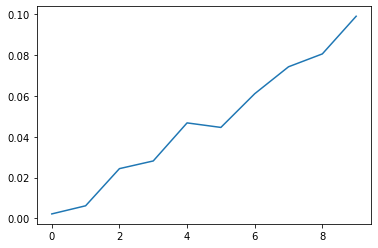

In [8]:
plt.plot(zs[:,0])

## Model